In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
df = pd.read_csv("/kaggle/input/grocery-inventory-and-sales-dataset/Grocery_Inventory_and_Sales_Dataset.csv")

In [9]:
# --- Fix Unit_Price (remove $ and spaces, convert to float) ---
df["Unit_Price"] = (
    df["Unit_Price"].astype(str)
    .str.replace(r"[^0-9.]", "", regex=True)
    .astype(float)
)

df['Expiration_Date'] = pd.to_datetime(df['Expiration_Date'], errors='coerce')
df['Date_Received'] = pd.to_datetime(df['Date_Received'], errors='coerce')

# Days remaining until expiry (from today)
df['DaysRemaining'] = (df['Expiration_Date'] - pd.Timestamp.today()).dt.days

# Average daily sales proxy (avoid divide by zero)
df['AvgDailySales'] = df['Sales_Volume'] / (df['DaysRemaining'].replace(0, np.nan))
df['AvgDailySales'] = df['AvgDailySales'].fillna(0)

# Target: 1 if stock will expire before being sold, else 0
df['WillExpire'] = np.where((df['Stock_Quantity'] > df['Sales_Volume']) & (df['DaysRemaining'] <= 0), 1, 0)

In [10]:
features = ['Stock_Quantity', 'Reorder_Level', 'Reorder_Quantity', 'Unit_Price',
            'Sales_Volume', 'DaysRemaining', 'AvgDailySales']
X = df[features]
y = df['WillExpire']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# --- Step 5: Predictions ---
y_pred = model.predict(X_test)

In [13]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9494949494949495

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.94      0.94      0.94        90

    accuracy                           0.95       198
   macro avg       0.95      0.95      0.95       198
weighted avg       0.95      0.95      0.95       198



In [14]:
comparison = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print(comparison.head(20))

     Actual  Predicted
893       0          0
110       1          1
82        1          1
727       1          1
186       1          0
355       1          1
217       0          0
451       1          1
226       1          0
945       0          0
370       0          0
973       0          0
861       1          1
616       1          1
820       1          1
908       0          0
928       1          1
182       0          0
613       0          0
446       0          0


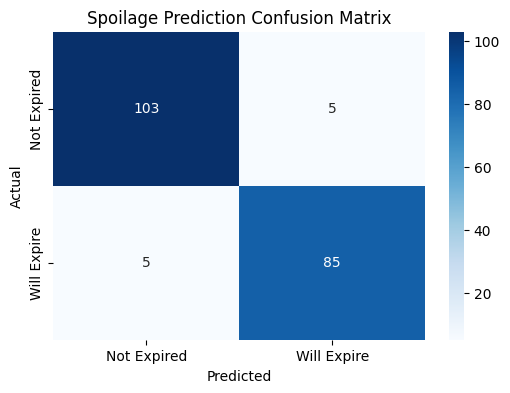

In [15]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues",
            xticklabels=["Not Expired", "Will Expire"],
            yticklabels=["Not Expired", "Will Expire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Spoilage Prediction Confusion Matrix")
plt.show()

In [16]:
import joblib

# Save the model
joblib.dump(model, "spoilage_model.pkl")

# Later, load the model
loaded_model = joblib.load("spoilage_model.pkl")
